In [63]:
# Imports, as always...
from pathlib import Path

import numpy as np
import pandas as pd

import torch

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [7]:
# Raw data.
raw_data = pd.concat([
    pd.read_csv(data_csv) 
    for data_csv in Path('./data/depth-varied').glob('*.csv')
], ignore_index=True)

In [ ]:
# Computing features from the raw data.
def get_features(df : pd.DataFrame, feature_type : str) -> torch.Tensor:
    # Small value for div-by-zero handling.
    eps = 1e-6
    
    # Fixed n.
    n = df['n'].iloc[0]
    
    # Relevant columns.
    x_cols = [col for col in df.columns if col.startswith('x')]
    y_cols = [col for col in df.columns if col.startswith('y')]
    
    # Relevant values.
    x_probs = torch.tensor(df[x_cols].values, dtype=torch.float64)
    y_probs = torch.tensor(df[y_cols].values, dtype=torch.float64)
    
    # Per-outcome feature types...
    
    if feature_type == 'raw':
        return x_probs
    
    if feature_type == 'res':
        return x_probs - y_probs
    
    if feature_type == 'abs_res':
        return (x_probs - y_probs).abs()
    
    if feature_type == 'rel_res':
        return (x_probs - y_probs) / (y_probs + eps)
    
    if feature_type == 'abs_rel_res':
        return (x_probs - y_probs).abs() / (y_probs + eps)
    
    if feature_type == 'log_ratio':
        return ((x_probs + eps) / (y_probs + eps)).log()
    
    # Per-qubit feature types...
    
    if feature_type == 'qubit_res':
        n_samples = x_probs.shape[0]
        residuals = x_probs - y_probs
        qubit_residuals = torch.zeros(n_samples, n, dtype=x_probs.dtype)
        
        for i in range(n):
            qubit_mask = torch.tensor([(j >> i) & 1 == 0 for j in range(2 ** n)], dtype=torch.bool)
            qubit_residuals[:, i] = residuals[:, qubit_mask].sum(dim=1)
            
        return qubit_residuals
    
    if feature_type == 'abs_qubit_res':
        n_samples = x_probs.shape[0]
        residuals = (x_probs - y_probs).abs()
        qubit_residuals = torch.zeros(n_samples, n, dtype=x_probs.dtype)
        
        for i in range(n):
            qubit_mask = torch.tensor([(j >> i) & 1 == 0 for j in range(2 ** n)], dtype=torch.bool)
            qubit_residuals[:, i] = residuals[:, qubit_mask].sum(dim=1)
            
        return qubit_residuals
    
    if feature_type == 'pauli_z_res':
        n_samples = x_probs.shape[0]
        residuals = x_probs - y_probs
        pauli_z_residuals = torch.zeros(n_samples, n, dtype=x_probs.dtype)
        
        for i in range(n):
            sign_vector = torch.tensor([1 - 2 * ((j >> i) & 1) for j in range(2 ** n)], dtype=x_probs.dtype)
            weighted_residual = residuals * sign_vector
            pauli_z_residuals[:, i] = weighted_residual.sum(dim=1)
            
        return pauli_z_residuals
    
    if feature_type == 'pauli_zz_res':
        n_samples = x_probs.shape[0]
        residuals = x_probs - y_probs
        
        n_pairs = n * (n - 1) // 2
        pauli_zz_residuals = torch.zeros(n_samples, n_pairs, dtype=x_probs.dtype)
        
        pair_idx = 0
        
        for i in range(n):
            for j in range(i + 1, n):
                sign_vector = torch.zeros(32, dtype=x_probs.dtype)
                for b in range(2 ** n):
                    b_i = (b >> i) & 1
                    b_j = (b >> j) & 1

                    if b_i == b_j: sign_vector[b] = 1.0
                    else: sign_vector[b] = -1.0
                    
                weighted_residual = residuals * sign_vector
                pauli_zz_residuals[:, pair_idx] = weighted_residual.sum(dim=1)
                pair_idx += 1
                
        return pauli_zz_residuals

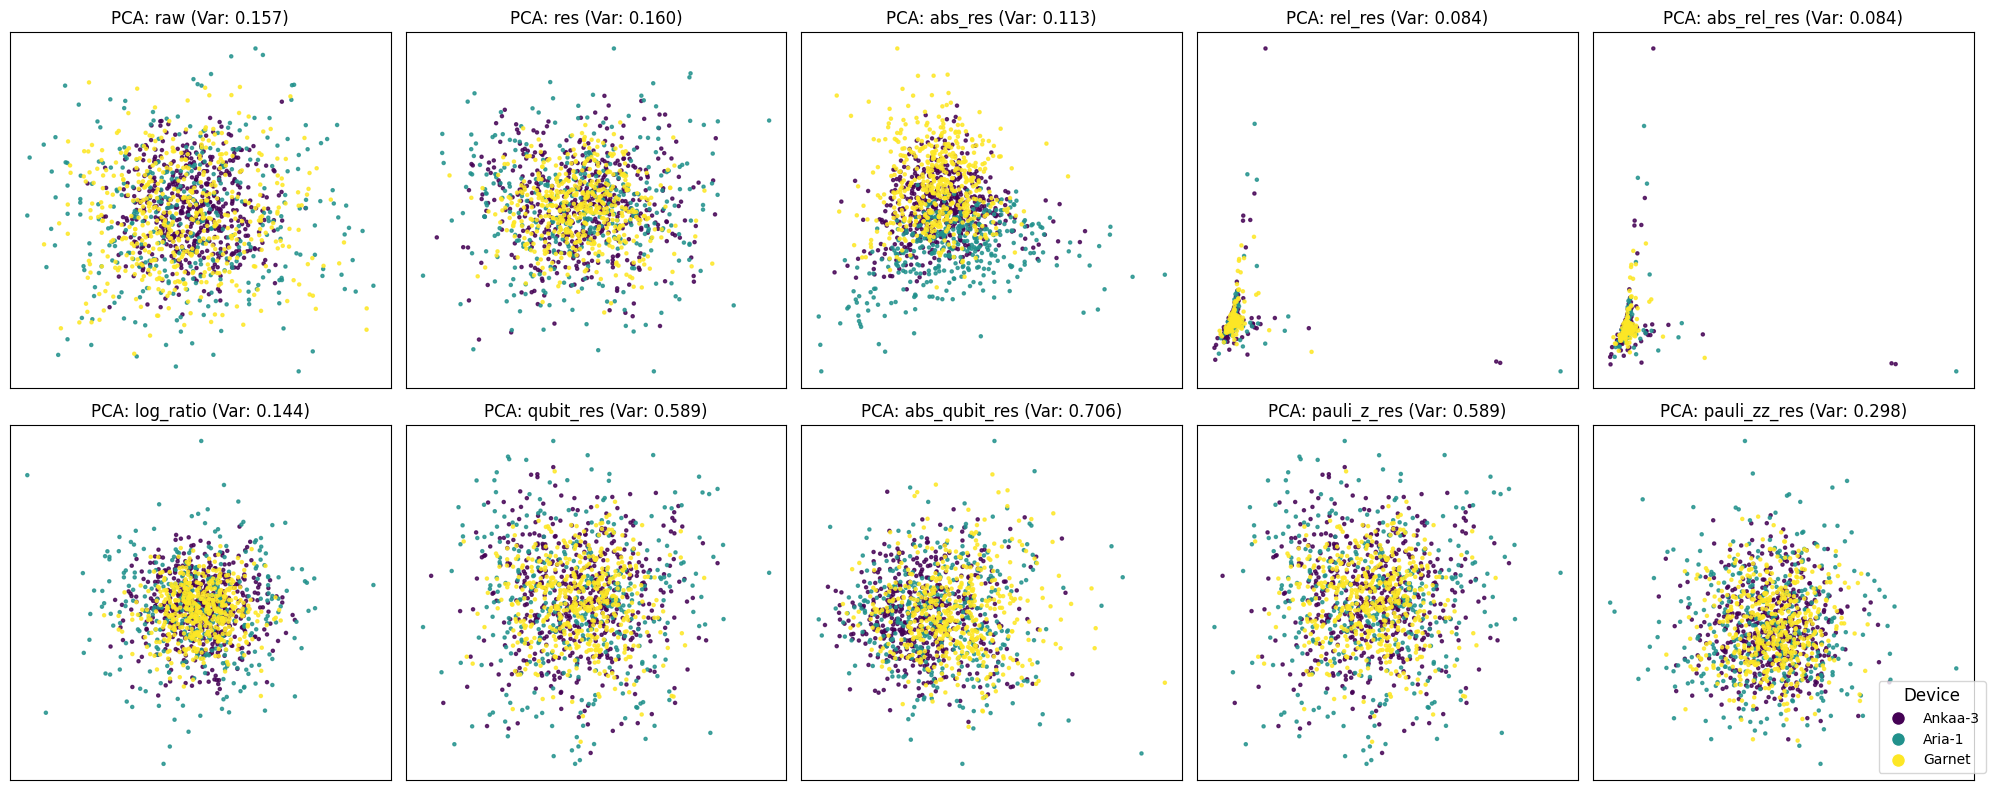

In [65]:
def plot_pca_features(df : pd.DataFrame):
    # Devices.
    unique_devices = sorted(df['device'].unique())
    n_devices = len(unique_devices)
    device_map = {d: i for i, d in enumerate(unique_devices)}
    device_labels = df['device'].map(device_map).values
    
    # Axes.
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    # Colours and handles.
    base_cmap = plt.colormaps.get_cmap('viridis')
    colours = base_cmap(np.linspace(0, 1, n_devices))
    cmap = ListedColormap(colours)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/(n_devices-1) if n_devices > 1 else 0), markersize=10, label=d) for i, d in enumerate(unique_devices)]
    
    # Compute features.
    all_features = {feature: get_features(df, feature) for feature in ['raw', 'res', 'abs_res', 'rel_res', 'abs_rel_res', 'log_ratio', 'qubit_res', 'abs_qubit_res', 'pauli_z_res', 'pauli_zz_res']}
    
    for i, (feature, tensor_data) in enumerate(all_features.items()):
        ax = axes[i]
        
        # Standardisation.
        scalar = StandardScaler()
        scaled_data = scalar.fit_transform(tensor_data.numpy())
        
        # PCA.
        pca = PCA(n_components=2)
        pca_data = pca.fit_transform(scaled_data)
        total_var = pca.explained_variance_ratio_.sum()
        
        # Plot.
        ax.scatter(
            pca_data[:, 0], 
            pca_data[:, 1], 
            c=device_labels, # Use integer labels for color mapping
            cmap=cmap, 
            vmin=0, # Ensure colors map correctly to the device indices (0 to N-1)
            vmax=n_devices-1,
            s=5, 
            alpha=.8,
            marker='o'
        )
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'PCA: {feature} (Var: {total_var:.3f})')
        
    plt.legend(
        handles=legend_handles,
        title='Device',
        loc='lower right', 
        bbox_to_anchor=(1.05, 0), # Place outside the rightmost plot
        fontsize=10,
        title_fontsize=12
    )
        
    plt.tight_layout()
    plt.show()
    
plot_pca_features(raw_data[raw_data['d'] == 5])

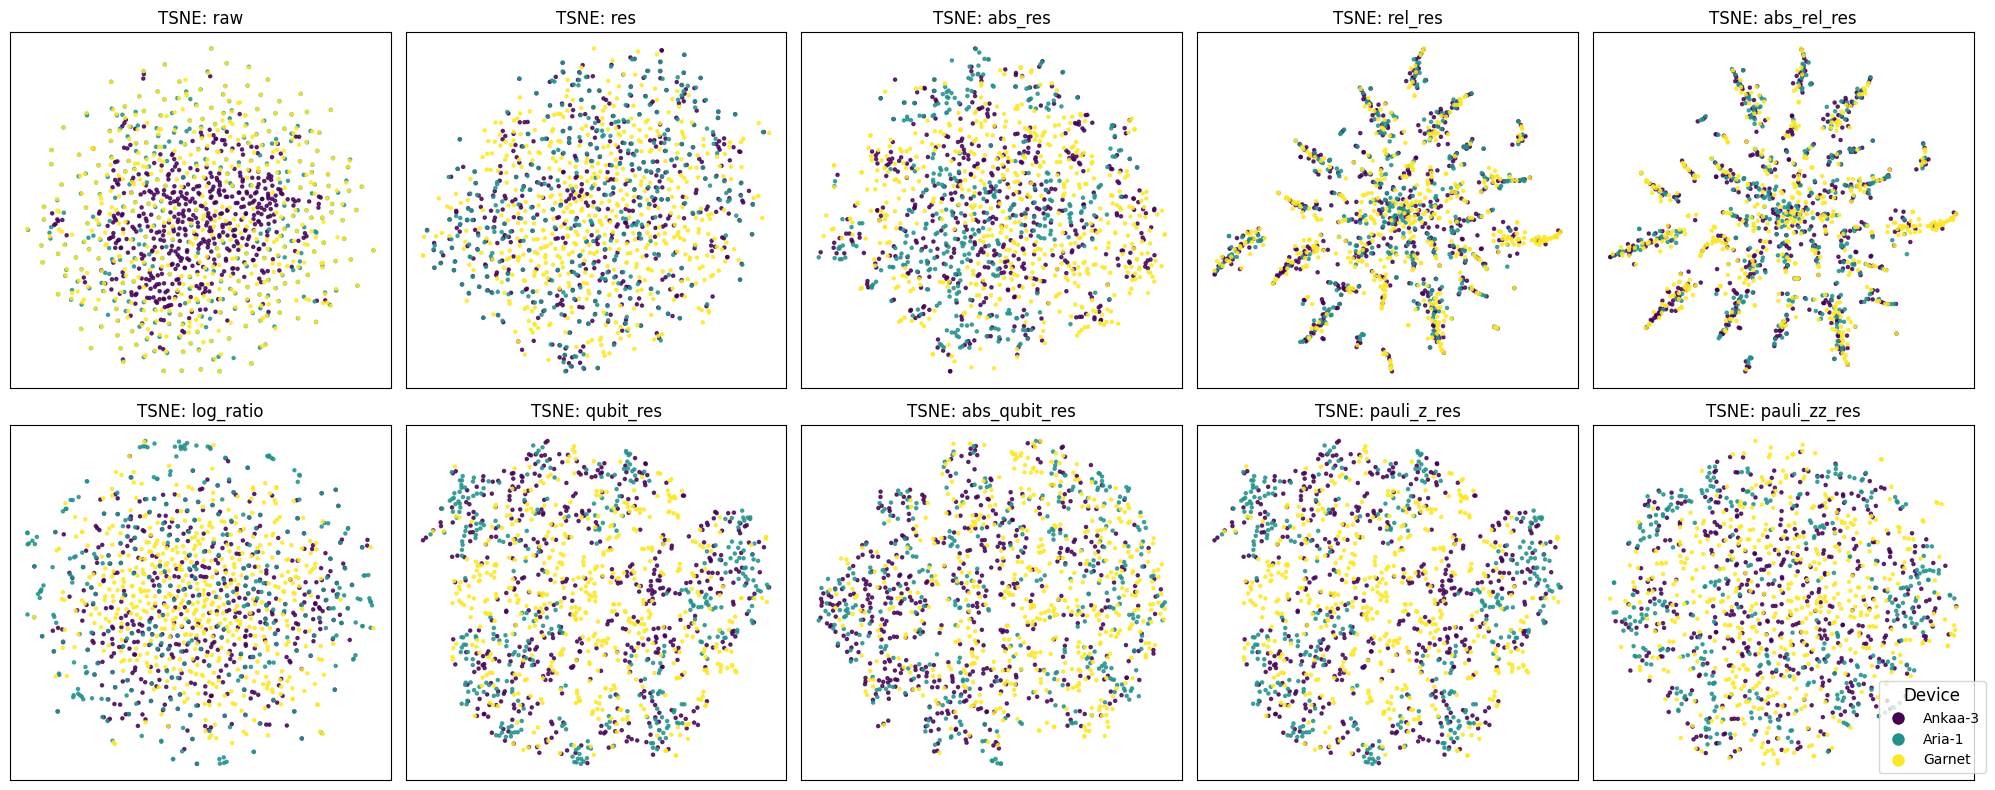

In [66]:
def plot_tsne_features(df : pd.DataFrame):
    # Devices.
    unique_devices = sorted(df['device'].unique())
    n_devices = len(unique_devices)
    device_map = {d: i for i, d in enumerate(unique_devices)}
    device_labels = df['device'].map(device_map).values
    
    # Axes.
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    # Colours and handles.
    base_cmap = plt.colormaps.get_cmap('viridis')
    colours = base_cmap(np.linspace(0, 1, n_devices))
    cmap = ListedColormap(colours)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/(n_devices-1) if n_devices > 1 else 0), markersize=10, label=d) for i, d in enumerate(unique_devices)]
    
    # Compute features.
    all_features = {feature: get_features(df, feature) for feature in ['raw', 'res', 'abs_res', 'rel_res', 'abs_rel_res', 'log_ratio', 'qubit_res', 'abs_qubit_res', 'pauli_z_res', 'pauli_zz_res']}
    
    for i, (feature, tensor_data) in enumerate(all_features.items()):
        ax = axes[i]
        
        # Standardisation.
        scalar = StandardScaler()
        scaled_data = scalar.fit_transform(tensor_data.numpy())
        
        # TSNE.
        tsne = TSNE(n_components=2, random_state=42)
        tsne_data = tsne.fit_transform(scaled_data)
        
        # Plot.
        ax.scatter(
            tsne_data[:, 0], 
            tsne_data[:, 1], 
            c=device_labels,
            cmap=cmap, 
            vmin=0,
            vmax=n_devices-1,
            s=5, 
            alpha=.8,
            marker='o'
        )
        
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f'TSNE: {feature}')
        
    plt.legend(
        handles=legend_handles,
        title='Device',
        loc='lower right', 
        bbox_to_anchor=(1.05, 0), # Place outside the rightmost plot
        fontsize=10,
        title_fontsize=12
    )
        
    plt.tight_layout()
    plt.show()
    
plot_tsne_features(raw_data[raw_data['d'] == 5])